In [2]:
import os
import glob

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image, UnidentifiedImageError

#Data importation, 
class CountingDataset(Dataset):
    def __init__(self, train_root, csv_path, transform=None):
    
        self.transform = transform or transforms.ToTensor()

        # load the CSV with the ground truth labels 
        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        # fix column names to match
        df = df.rename(columns={
            "frame_name":             "frame",
            "sperm_count":            "sperm",
            "cluster_count":          "cluster",
            "small_or_pinhead_count": "pinhead"
        })

        # lookup to find torch([sperm, cluster, pinhead])
        self.counts_map = {
            row["frame"]: torch.tensor(
                [row["sperm"], row["cluster"], row["pinhead"]],
                dtype=torch.float32
            )
            for _, row in df.iterrows()
        }

        # Now we have to gather image paths & filter out the ones that dont have 
        # corresponding CSV truth lables or are corrupted 
        pattern = os.path.join(train_root, "**", "*.jpg")
        all_paths = glob.glob(pattern, recursive=True)

        self.samples = []
        for img_path in all_paths:
            stem = os.path.splitext(os.path.basename(img_path))[0]
            if stem not in self.counts_map:
                continue

            try:
                with Image.open(img_path) as img:
                    img.verify()
                self.samples.append((stem, img_path))
            except (UnidentifiedImageError, IOError):
                print(f" Skipping corrupted image {img_path}")

        if not self.samples:
            raise RuntimeError(f"No valid images found in {train_root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame, img_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        counts = self.counts_map[frame]
        return img, counts

# Getting the data
PROJECT_ROOT = "/gpfs/gibbs/project/cpsc452/cpsc452_tec46"
CSV_PATH     = os.path.join(PROJECT_ROOT, "sperm_counts_per_frame.csv")
TRAIN_DIR    = os.path.join(PROJECT_ROOT, "Train")

# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),

    # blur 30% of the time
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5)
    ], p=0.3),

    # color jitter 50% of the time
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2
        )
    ], p=0.3),

    transforms.ToTensor(),
])

# making the full dataset
dataset = CountingDataset(
    train_root = TRAIN_DIR,
    csv_path   = CSV_PATH,
    transform  = transform
)

# Train / validation split (80% / 20%) and fixed seed 
total_count = len(dataset)
val_count   = int(0.2 * total_count)
train_count = total_count - val_count

train_ds, val_ds = random_split(
    dataset,
    [train_count, val_count],
    generator=torch.Generator().manual_seed(42)
)

# dataLoaders:
train_loader = DataLoader(
    train_ds,
    batch_size   = 8,
    shuffle      = True,
    num_workers  = 1,
    pin_memory   = True,
)

val_loader = DataLoader(
    val_ds,
    batch_size   = 8,
    shuffle      = False,
    num_workers  = 1,
    pin_memory   = True,
)

# checking the shapes
print(f"The total training samples are {total_count}")
print(f"Training samples:  {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

imgs, counts = next(iter(train_loader))
print("Image batch shape is", imgs.shape)    # e.g. torch.Size([8,3,480,640])
print("Count batch shape is", counts.shape) # torch.Size([8,3])

 Skipping corrupted image /gpfs/gibbs/project/cpsc452/cpsc452_tec46/Train/36/images/36_frame_517.jpg
 Skipping corrupted image /gpfs/gibbs/project/cpsc452/cpsc452_tec46/Train/29/images/29_frame_1382.jpg
 Skipping corrupted image /gpfs/gibbs/project/cpsc452/cpsc452_tec46/Train/35/images/35_frame_110.jpg
The total training samples are 18560
Training samples:  14848
Validation samples: 3712
Image batch shape is torch.Size([8, 3, 480, 640])
Count batch shape is torch.Size([8, 3])


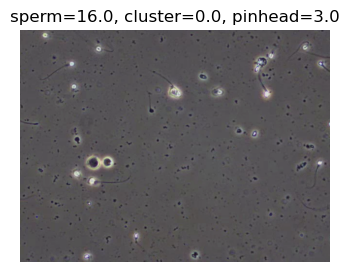

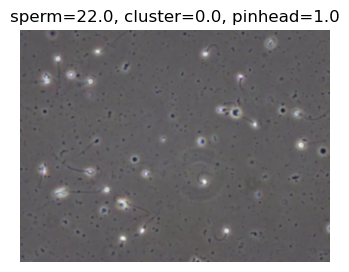

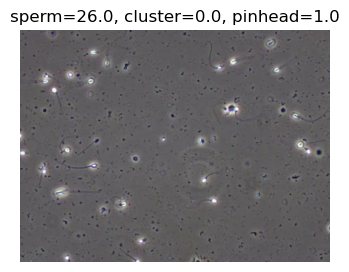

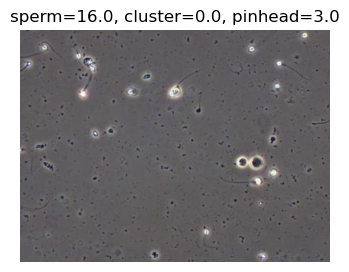

In [2]:
import matplotlib.pyplot as plt

#Image of what the datasamples look like, and their corresponding truth labels 
for i in range(4):
    img, counts = dataset[i]
    plt.figure(figsize=(4, 4))
    plt.imshow(img.permute(1, 2, 0))      
    plt.title(f"sperm={counts[0]}, cluster={counts[1]}, pinhead={counts[2]}")
    plt.axis("off")
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_spatial=0.1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_spatial),            
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.layers(x)

#MaxPool to DoubleConv
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch))
    def forward(self, x):
        return self.net(x)
        
#Takes # of image channels, number of filters in the first block and dropout probability 
class CountUNetRegressor(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, dropout_p=0.3):
        super().__init__()
        
        # just the encoder here 
        self.inc   = DoubleConv(in_channels, base_channels)            # 3 to 64
        self.down1 = Down(base_channels,   base_channels * 2)           # 64 to 128
        self.down2 = Down(base_channels*2, base_channels * 4)           # 128 to 256
        self.down3 = Down(base_channels*4, base_channels * 8)           # 256 to 512
        self.down4 = Down(base_channels*8, base_channels * 16)         # 512 to 1024

        # dual pooling to MLP with BN + ReLU + Dropout
        feat_dim = base_channels * 16  
        self.head = nn.Sequential(
            nn.Linear(feat_dim * 2, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.BatchNorm1d(feat_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(feat_dim // 2, 3)   # this outputs [sperm, cluster, pinhead]
        )

    def forward(self, x):
        # encoder forward
        x1 = self.inc(x)      
        x2 = self.down1(x1)   
        x3 = self.down2(x2)   
        x4 = self.down3(x3)   
        x5 = self.down4(x4)   
        
        # dual pooling on the bottleneck
        avgp = F.adaptive_avg_pool2d(x5, 1) 
        maxp = F.adaptive_max_pool2d(x5, 1)  
        v = torch.cat([avgp, maxp], dim=1)   
        v = v.view(v.size(0), -1)            

        # returns our 3 vector
        return self.head(v)

In [5]:
from tqdm import tqdm

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

# Had to debug so checking device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model  = CountUNetRegressor(in_channels=3, base_channels=64, dropout_p=0.3)
model  = model.to(device)

# Loss, optimizer, scheduler 
criterion = nn.L1Loss()  # MAE for counts
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

num_epochs = 20
patience   = 5
total_steps = num_epochs * len(train_loader)
best_val_mae = float("inf")
wait = 0

scheduler = OneCycleLR(
     optimizer,
     max_lr=1e-3,              
     total_steps=total_steps,
     pct_start=0.3,             
     anneal_strategy="linear"
 )

# epoch functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="  Train", leave=False)
    for imgs, targets in pbar:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss  = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()   

        running_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(batch_loss=loss.item())

    return running_loss / len(loader.dataset)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        pbar = tqdm(loader, desc="  Val  ", leave=False)
        for imgs, targets in pbar:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss  = criterion(preds, targets)
            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix(batch_loss=loss.item())
    return running_loss / len(loader.dataset)

# training 
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch:02d}/{num_epochs:02d}")

    train_mae = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"  → Train MAE: {train_mae:.4f}")

    val_mae = validate_one_epoch(model, val_loader, criterion, device)
    print(f"  → Val   MAE: {val_mae:.4f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f" Saved new best (Val MAE: {val_mae:.4f})")
    else:
        wait += 1
        print(f"  ↩  No improvement ({wait}/{patience})")
        if wait >= patience:
            print(f"Early stopping: no val‐MAE improvement for {patience} epochs")
            break

print(f"\nTraining complete, best Val MAE was: {best_val_mae:.4f}")

Using device: cuda

Epoch 01/20


  → Train MAE: 4.0725


  → Val   MAE: 2.0648
 Saved new best (Val MAE: 2.0648)

Epoch 02/20


  → Train MAE: 2.1444


  → Val   MAE: 3.1739
  ↩  No improvement (1/5)

Epoch 03/20


  → Train MAE: 2.0108


  → Val   MAE: 1.7683
 Saved new best (Val MAE: 1.7683)

Epoch 04/20


  → Train MAE: 2.0129


  → Val   MAE: 1.8185
  ↩  No improvement (1/5)

Epoch 05/20


  → Train MAE: 1.9883


  → Val   MAE: 1.2418
 Saved new best (Val MAE: 1.2418)

Epoch 06/20


  → Train MAE: 1.9444


  → Val   MAE: 1.5918
  ↩  No improvement (1/5)

Epoch 07/20


  → Train MAE: 1.8874


  → Val   MAE: 1.0215
 Saved new best (Val MAE: 1.0215)

Epoch 08/20


  → Train MAE: 1.7207


  → Val   MAE: 1.2270
  ↩  No improvement (1/5)

Epoch 09/20


  → Train MAE: 1.5417


  → Val   MAE: 0.8490
 Saved new best (Val MAE: 0.8490)

Epoch 10/20


  → Train MAE: 1.4520


  → Val   MAE: 0.9355
  ↩  No improvement (1/5)

Epoch 11/20


  → Train MAE: 1.3815


  → Val   MAE: 0.8357
 Saved new best (Val MAE: 0.8357)

Epoch 12/20


  → Train MAE: 1.3209


  → Val   MAE: 0.8042
 Saved new best (Val MAE: 0.8042)

Epoch 13/20


  → Train MAE: 1.2464


  → Val   MAE: 1.0715
  ↩  No improvement (1/5)

Epoch 14/20


  → Train MAE: 1.2088


  → Val   MAE: 0.9324
  ↩  No improvement (2/5)

Epoch 15/20


  → Train MAE: 1.1480


  → Val   MAE: 0.6202
 Saved new best (Val MAE: 0.6202)

Epoch 16/20


  → Train MAE: 1.0989


  → Val   MAE: 0.6507
  ↩  No improvement (1/5)

Epoch 17/20


  → Train MAE: 1.0580


  → Val   MAE: 0.5807
 Saved new best (Val MAE: 0.5807)

Epoch 18/20


  → Train MAE: 1.0407


  → Val   MAE: 0.9449
  ↩  No improvement (1/5)

Epoch 19/20


  → Train MAE: 1.0138


  → Val   MAE: 1.0272
  ↩  No improvement (2/5)

Epoch 20/20


  → Train MAE: 0.9534


  → Val   MAE: 0.8306
  ↩  No improvement (3/5)

Training complete, best Val MAE was: 0.5807


In [6]:
# Plotting predictions versus truth
model = CountUNetRegressor(in_channels=3, base_channels=64, dropout_p=0.3)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# predictions & ground truth
all_preds, all_targets = [], []
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = imgs.to(device)
        outs = model(imgs).cpu()      
        all_preds.append(outs)
        all_targets.append(targets)  

preds = torch.cat(all_preds, dim=0)    
targs = torch.cat(all_targets, dim=0)  

# Now get a per class scatter plot with true line of fit
class_names = ["sperm", "cluster", "pinhead"]
plt.figure(figsize=(18, 6))
for i, name in enumerate(class_names):
    plt.subplot(1, 3, i+1)
    mn = min(targs[:, i].min(), preds[:, i].min()).item()
    mx = max(targs[:, i].max(), preds[:, i].max()).item()
    
    plt.plot([mn, mx], [mn, mx], color="blue", linewidth=2, label="Perfect (y = x)")
    
    # scatter predictions 
    plt.scatter(targs[:, i].numpy(), preds[:, i].numpy(), color="red", alpha=0.4, edgecolor="k", label="Model predictions")
    
    plt.xlabel(f"True {name} count")
    plt.ylabel(f"Predicted {name} count")
    plt.title(f"{name.capitalize()} count: True vs. Predicted")
    plt.legend(loc="upper left")  # or "best"
    
plt.tight_layout()
plt.show()

Using device: cuda


/tmp/ipykernel_4028222/1217175174.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


KeyboardInterrupt: 

In [7]:
# Now, for the improved model with SE blocks, it learns a weight per channel
class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1     = nn.Linear(channels, channels // reduction)
        self.relu    = nn.ReLU(inplace=True)
        self.fc2     = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        # bottleneck
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        # scale channels
        return x * y

# two conv layers + SE
class DoubleConvSE(nn.Module):
    def __init__(self, in_ch, out_ch, reduction=16):
        super().__init__()
        # two 3×3 convs
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.se = SqueezeExcitation(out_ch, reduction)

    def forward(self, x):
        x = self.conv(x)
        return self.se(x)

# Next downsample (maxpool) then DoubleConvSE
class DownSE(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvSE(in_ch, out_ch)
        )
    def forward(self, x):
        return self.net(x)

# full model
class CountUNetSE(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, dropout_p=0.3):
        super().__init__()
        self.inc   = DoubleConvSE(in_channels, base_channels)         
        self.down1 = DownSE(base_channels,   base_channels * 2)       
        self.down2 = DownSE(base_channels*2, base_channels * 4)       
        self.down3 = DownSE(base_channels*4, base_channels * 8)       
        self.down4 = DownSE(base_channels*8, base_channels * 16)      

        # pool features then MLP to 3 outputs
        feat_dim = base_channels * 16  
        self.head = nn.Sequential(
            nn.Linear(feat_dim * 2, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),

            nn.Linear(feat_dim, feat_dim // 2),
            nn.BatchNorm1d(feat_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),

            nn.Linear(feat_dim // 2, 3)  
        )

    def forward(self, x):
        x1 = self.inc(x)      
        x2 = self.down1(x1)   
        x3 = self.down2(x2)   
        x4 = self.down3(x3)   
        x5 = self.down4(x4)   
        # global avgpool
        avgp = F.adaptive_avg_pool2d(x5, 1)
        # global maxpool
        maxp = F.adaptive_max_pool2d(x5, 1)
        # flatten both and concat to [B, 2048]
        v = torch.cat([avgp, maxp], dim=1).view(x5.size(0), -1)
        # final MLP
        return self.head(v)


In [13]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model       = CountUNetSE(in_channels=3, base_channels=64, dropout_p=0.2).to(device)
criterion   = nn.L1Loss()                         
optimizer   = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

num_epochs  = 20
patience    = 5
total_steps = num_epochs * len(train_loader)      
best_val_mae = float("inf")
wait         = 0

scheduler = OneCycleLR(
    optimizer,
    max_lr=5e-3,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy="cos"
)

# epoch functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, targets in tqdm(loader, desc="  Train", leave=False):
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss  = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()    

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="  Val  ", leave=False):
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            running_loss += criterion(preds, targets).item() * imgs.size(0)
    return running_loss / len(loader.dataset)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch:02d}/{num_epochs:02d}")

    train_mae = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"  → Train MAE: {train_mae:.4f}")

    val_mae = validate_one_epoch(model, val_loader, criterion, device)
    print(f"  → Val   MAE: {val_mae:.4f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        wait = 0
        torch.save(model.state_dict(), "best_se_model.pth")
        print(f" Saved new best (Val MAE: {val_mae:.4f})")
    else:
        wait += 1
        print(f"  ↩  No improvement ({wait}/{patience})")
        if wait >= patience:
            print(f"Early stopping: no val‐MAE improvement for {patience} epochs")
            break

print(f"\nTraining complete. Best Val MAE: {best_val_mae:.4f}")


Epoch 01/20


  → Train MAE: 3.0118


  → Val   MAE: 2.4076
 Saved new best (Val MAE: 2.4076)

Epoch 02/20


  → Train MAE: 2.0969


  → Val   MAE: 1.7438
 Saved new best (Val MAE: 1.7438)

Epoch 03/20


  → Train MAE: 1.5911


  → Val   MAE: 1.2225
 Saved new best (Val MAE: 1.2225)

Epoch 04/20


  → Train MAE: 1.3356


  → Val   MAE: 0.8725
 Saved new best (Val MAE: 0.8725)

Epoch 05/20


  → Train MAE: 1.2327


  → Val   MAE: 1.2197
  ↩  No improvement (1/5)

Epoch 06/20


  → Train MAE: 1.1423


  → Val   MAE: 0.7294
 Saved new best (Val MAE: 0.7294)

Epoch 07/20


  → Train MAE: 1.0558


  → Val   MAE: 0.5441
 Saved new best (Val MAE: 0.5441)

Epoch 08/20


  → Train MAE: 0.9832


  → Val   MAE: 0.6415
  ↩  No improvement (1/5)

Epoch 09/20


  → Train MAE: 0.9498


  → Val   MAE: 0.6663
  ↩  No improvement (2/5)

Epoch 10/20


  → Train MAE: 0.9004


  → Val   MAE: 0.6336
  ↩  No improvement (3/5)

Epoch 11/20


  → Train MAE: 0.8435


  → Val   MAE: 0.8771
  ↩  No improvement (4/5)

Epoch 12/20


  → Train MAE: 0.7940


  → Val   MAE: 0.8169
  ↩  No improvement (5/5)
Early stopping: no val‐MAE improvement for 5 epochs

Training complete. Best Val MAE: 0.5441


In [8]:
# Now again to plot predictions versus truth scatter plot:
model = CountUNetSE(in_channels=3, base_channels=64, dropout_p=0.2).to(device)
model.load_state_dict(torch.load("best_se_model.pth", map_location=device))
model.to(device)
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = imgs.to(device)
        outs = model(imgs).cpu()       
        all_preds.append(outs)
        all_targets.append(targets)    

preds = torch.cat(all_preds, dim=0)    
targs = torch.cat(all_targets, dim=0)  

class_names = ["sperm", "cluster", "pinhead"]
plt.figure(figsize=(18, 6))
for i, name in enumerate(class_names):
    plt.subplot(1, 3, i+1)
    mn = min(targs[:, i].min(), preds[:, i].min()).item()
    mx = max(targs[:, i].max(), preds[:, i].max()).item()
    
    plt.plot([mn, mx], [mn, mx], color="blue", linewidth=2, label="Perfect (y = x)")
    
    plt.scatter(targs[:, i].numpy(), preds[:, i].numpy(), color="black", alpha=0.3, edgecolor="k", label="Model predictions")
    
    plt.xlabel(f"True {name} count")
    plt.ylabel(f"Predicted {name} count")
    plt.title(f"{name.capitalize()} count: True vs. Predicted")
    plt.legend(loc="upper left")  # or "best"
    
plt.tight_layout()
plt.show()

/tmp/ipykernel_4028222/394247513.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_se_model.pth", map_location=device))


KeyboardInterrupt: 

In [10]:
# Testing both models:
PROJECT_ROOT = "/gpfs/gibbs/project/cpsc452/cpsc452_tec46"
CSV_PATH     = os.path.join(PROJECT_ROOT, "sperm_counts_per_frame.csv")
TEST_DIR     = os.path.join(PROJECT_ROOT, "Test", "82")  

test_ds = CountingDataset(
    train_root = TEST_DIR,
    csv_path   = CSV_PATH,
    transform  = transform    
)

test_loader = DataLoader(
    test_ds,
    batch_size   = 8,
    shuffle      = False,
    num_workers  = 1,
    pin_memory   = True,
)

print(f"Test samples: {len(test_ds)}")

# helper to compute MAE
def evaluate(model, loader, device):
    model.eval()
    total_abs_err = 0.0
    loss_fn = nn.L1Loss(reduction="sum")
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc=f"Evaluating {model.__class__.__name__}"):
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            total_abs_err += loss_fn(preds, targets).item()
    return total_abs_err / len(loader.dataset)

# Loading both models 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = CountUNetRegressor(in_channels=3, base_channels=64, dropout_p=0.3)
se_model   = CountUNetSE(       in_channels=3, base_channels=64, dropout_p=0.1)
base_model.load_state_dict(torch.load("best_model.pth",    map_location=device))
se_model.  load_state_dict(torch.load("best_se_model.pth", map_location=device))

base_model.to(device)
se_model.  to(device)

# evaluate:
base_mae = evaluate(base_model, test_loader, device)
se_mae   = evaluate(se_model,   test_loader, device)
print(f"\nBase UNet   MAE on Test: {base_mae:.4f}")
print(f"SE‐UNet     MAE on Test: {se_mae:.4f}")

Test samples: 1500


/tmp/ipykernel_4028222/1627938145.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("best_model.pth",    map_location=device))
/tmp/


Base UNet   MAE on Test: 6.9899
SE‐UNet     MAE on Test: 5.2075


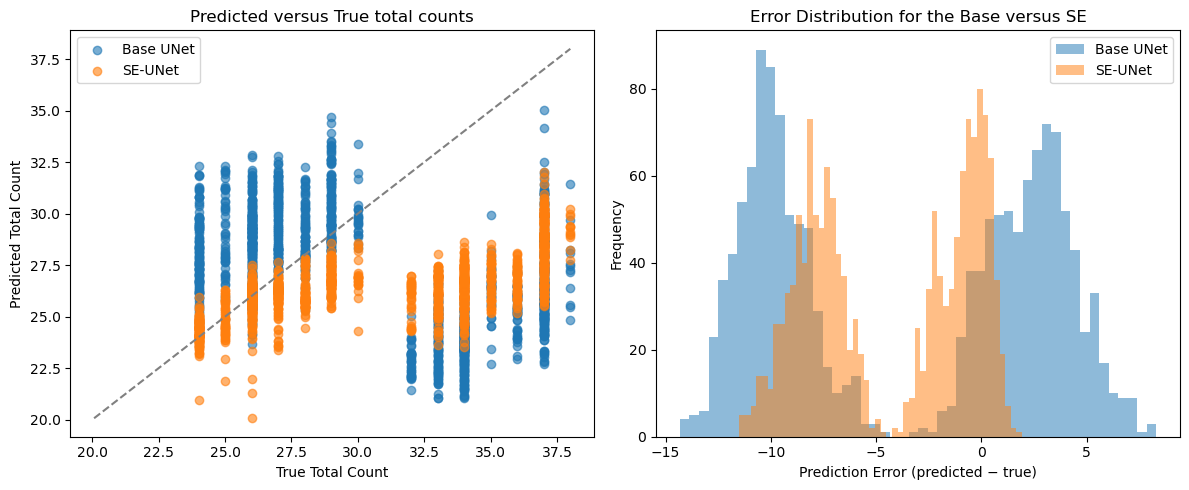

In [12]:
import numpy as np 

# All predictions and targets
base_preds_list, se_preds_list, targets_list = [], [], []
base_model.eval()
se_model.eval()

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = imgs.to(device)
        b_out = base_model(imgs).cpu().numpy()
        s_out = se_model(imgs).cpu().numpy()
        t_gt  = targets.numpy()

        base_preds_list.append(b_out)
        se_preds_list.append(s_out)
        targets_list.append(t_gt)

base_preds = np.concatenate(base_preds_list, axis=0)  
se_preds   = np.concatenate(se_preds_list,   axis=0)  
targets    = np.concatenate(targets_list,    axis=0)  

# compute the totals & errors 
true_sum  = targets.sum(axis=1) 
base_sum  = base_preds.sum(axis=1) 
se_sum    = se_preds.sum(axis=1)

base_err  = base_sum - true_sum
se_err    = se_sum   - true_sum

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)
plt.scatter(true_sum, base_sum, label="Base UNet", alpha=0.6)
plt.scatter(true_sum, se_sum,   label="SE-UNet",  alpha=0.6)

mn = min(true_sum.min(), base_sum.min(), se_sum.min())
mx = max(true_sum.max(), base_sum.max(), se_sum.max())
plt.plot([mn, mx], [mn, mx], "--", color="gray")

plt.xlabel("True Total Count")
plt.ylabel("Predicted Total Count")
plt.title("Predicted versus True total counts")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(base_err, bins=50, alpha=0.5, label="Base UNet")
plt.hist(se_err,   bins=50, alpha=0.5, label="SE-UNet")

plt.xlabel("Prediction Error (predicted − true)")
plt.ylabel("Frequency")
plt.title("Error Distribution for the Base versus SE")
plt.legend()

plt.tight_layout()
plt.show()